# Amr Mohamed Hassan 37-2562

# Importing libraries

In [1]:
import os 
import numpy as np
import pandas as pd
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from scipy.stats import pearsonr
from sklearn.model_selection import KFold
%matplotlib inline

# Importing dataset

In [2]:
data = pd.read_csv(r'Data/house_data_complete.csv')
data.shape

(21613, 21)

# Filtering data from NA and missing data fields

In [3]:
data.dropna()
data.shape

(21613, 21)

# Removing unneccesary features and cleaning the data

In [4]:
#sqft_above is the difference between sqftliving and sqftbasement
#sqft_living15 and sqft_lot15 is the average with the surrounding 15 houses
data = data.drop(["id","date","sqft_above","zipcode","lat","long","sqft_living15","sqft_lot15"],axis = 1)
data = data.drop(data[data.bedrooms>8].index)
data = data.drop(data[data.bathrooms>=5].index)
data = data.drop(data[data.sqft_living>10000].index)
data = data.drop(data[data.sqft_lot>150000].index)


# Changing the dataframe to numpy array

In [5]:
data_np = data.to_numpy()
print(data_np.shape)
print(data_np)

(21215, 13)
[[2.21900e+05 3.00000e+00 1.00000e+00 ... 0.00000e+00 1.95500e+03
  0.00000e+00]
 [5.38000e+05 3.00000e+00 2.25000e+00 ... 4.00000e+02 1.95100e+03
  1.99100e+03]
 [1.80000e+05 2.00000e+00 1.00000e+00 ... 0.00000e+00 1.93300e+03
  0.00000e+00]
 ...
 [4.02101e+05 2.00000e+00 7.50000e-01 ... 0.00000e+00 2.00900e+03
  0.00000e+00]
 [4.00000e+05 3.00000e+00 2.50000e+00 ... 0.00000e+00 2.00400e+03
  0.00000e+00]
 [3.25000e+05 2.00000e+00 7.50000e-01 ... 0.00000e+00 2.00800e+03
  0.00000e+00]]


# Plotting function

In [6]:
def plotData(x, y,xlabel,ylabel):

    fig = pyplot.figure() 
    pyplot.plot(x, y, 'ro', ms=10, mec='k')
    pyplot.ylabel(ylabel)
    pyplot.xlabel(xlabel)

# Visualize the data 

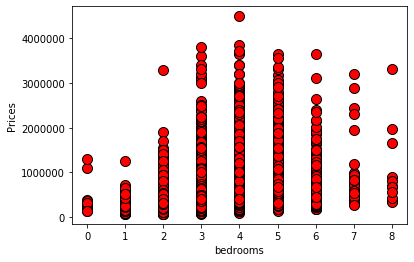

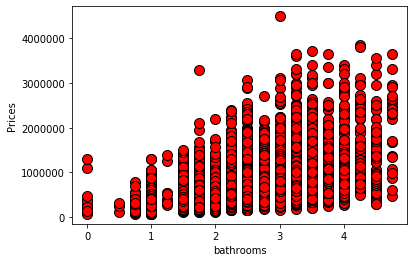

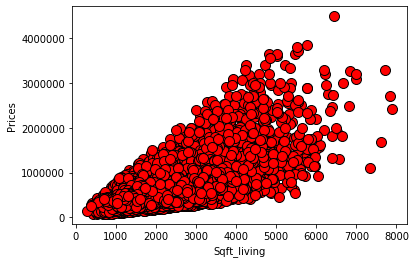

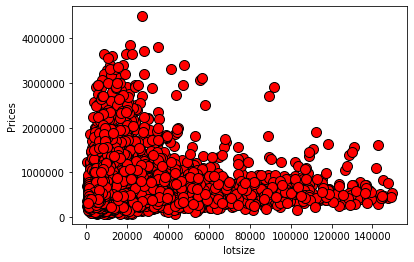

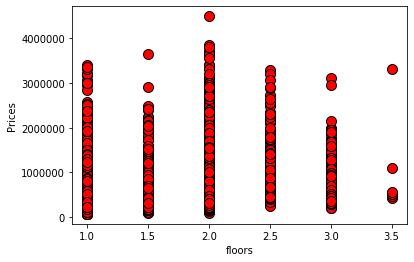

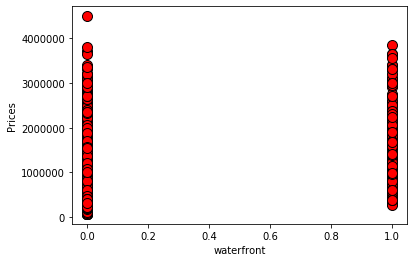

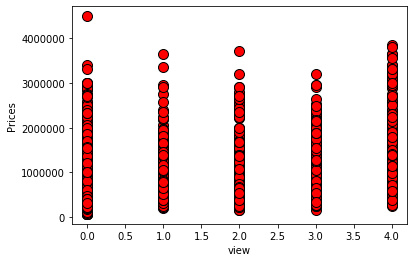

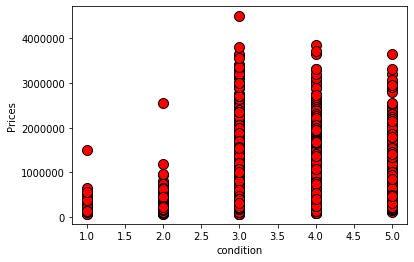

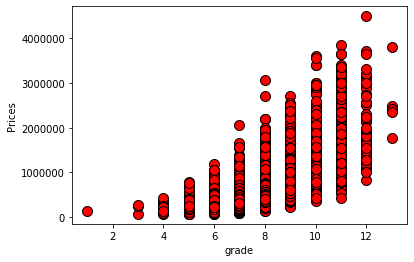

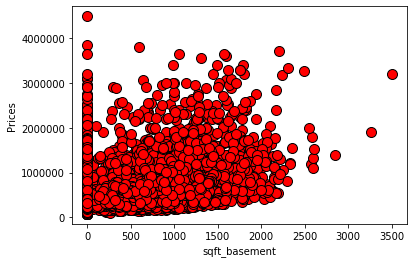

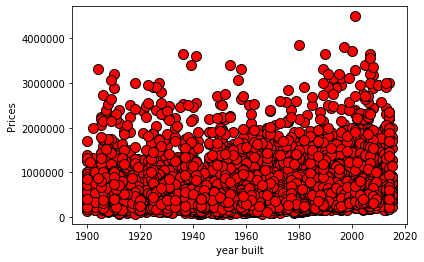

In [7]:
prices = data_np[:,0]
bedrooms = data_np[:,1]
bathrooms = data_np[:,2]
livingsize = data_np[:,3]
lotsize = data_np[:,4]
floors = data_np[:,5]
waterfront = data_np[:,6]
view = data_np[:,7]
condition = data_np[:,8]
grade = data_np[:,9]
sqft_basement = data_np[:,10]
yearbuilt = data_np[:,11]

plotData(bedrooms,prices,"bedrooms","Prices")
plotData(bathrooms,prices,"bathrooms","Prices")
plotData(livingsize,prices,"Sqft_living","Prices")
plotData(lotsize,prices,"lotsize","Prices")
plotData(floors,prices,"floors","Prices")
plotData(waterfront,prices,"waterfront","Prices")
plotData(view,prices,"view","Prices")
plotData(condition,prices,"condition","Prices")
plotData(grade,prices,"grade","Prices")
plotData(sqft_basement,prices,"sqft_basement","Prices")
plotData(yearbuilt,prices,"year built","Prices")




# Separating labels and features

In [8]:
y = data_np[:,0]
X = data_np[:,1:]
X_train,X_testval,y_train,y_testval = train_test_split(X,y,test_size = 0.3,shuffle = True)
X_val,X_test,y_val,y_test = train_test_split(X_testval,y_testval,test_size = 0.333333333333,shuffle = True)

print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)
print(X_val.shape,y_val.shape)

(14850, 12) (14850,)
(2122, 12) (2122,)
(4243, 12) (4243,)


# Normalizing features and adding intercept term

In [9]:
def featureNormalize(X):


    X_norm = X.copy()
    mu = np.zeros(X.shape[0])
    sigma = np.zeros(X.shape[0])
    mu = np.mean(X, axis = 0)
    sigma = np.std(X, axis = 0)
    X_norm = (X - mu) / sigma

    return X_norm, mu, sigma

In [10]:
X_trainnorm,mu,sigma = featureNormalize(X_train)

In [11]:
#Normalizing testing and validation data 
X_testnorm = (X_test - mu)/sigma
X_valnorm = (X_val - mu)/sigma

print(X_trainnorm.shape,y_train.shape)
print(X_testnorm.shape,y_test.shape)
print(X_valnorm.shape,y_val.shape)

(14850, 12) (14850,)
(2122, 12) (2122,)
(4243, 12) (4243,)


In [12]:
#Adding intercept term to the training, validation and testing sets 
X_trainnorm = np.concatenate([np.ones((y_train.size, 1)), X_trainnorm], axis=1)
X_testnorm = np.concatenate([np.ones((y_test.size, 1)), X_testnorm], axis=1)
X_valnorm = np.concatenate([np.ones((y_val.size, 1)), X_valnorm], axis=1)

print(X_trainnorm.shape,y_train.shape)
print(X_testnorm.shape,y_test.shape)
print(X_valnorm.shape,y_val.shape)

(14850, 13) (14850,)
(2122, 13) (2122,)
(4243, 13) (4243,)


# Cost function and gradient decent 

In [13]:
def computeCostMulti(X, y, theta):
    """
    Compute cost for linear regression with multiple variables.
    Computes the cost of using theta as the parameter for linear regression to fit the data points in X and y.
    
    Parameters
    ----------
    X : array_like
        The dataset of shape (m x n+1).
    
    y : array_like
        A vector of shape (m, ) for the values at a given data point.
    
    theta : array_like
        The linear regression parameters. A vector of shape (n+1, )
    
    Returns
    -------
    J : float
        The value of the cost function. 
    
    Instructions
    ------------
    Compute the cost of a particular choice of theta. You should set J to the cost.
    """
    # Initialize some useful values
    m = y.shape[0] # number of training examples
    
    # You need to return the following variable correctly
    J = 0
    
    # ======================= YOUR CODE HERE ===========================
    
    J= (1/(2*m)) * np.dot(np.transpose(np.dot(X,theta)-y),np.dot(X,theta)-y)
    
    # ==================================================================
    return J

In [14]:
def gradientDescentMulti(X, y, theta, alpha, num_iters):
    """
    Performs gradient descent to learn theta.
    Updates theta by taking num_iters gradient steps with learning rate alpha.
        
    Parameters
    ----------
    X : array_like
        The dataset of shape (m x n+1).
    
    y : array_like
        A vector of shape (m, ) for the values at a given data point.
    
    theta : array_like
        The linear regression parameters. A vector of shape (n+1, )
    
    alpha : float
        The learning rate for gradient descent. 
    
    num_iters : int
        The number of iterations to run gradient descent. 
    
    Returns
    -------
    theta : array_like
        The learned linear regression parameters. A vector of shape (n+1, ).
    
    J_history : list
        A python list for the values of the cost function after each iteration.
    
    Instructions
    ------------
    Peform a single gradient step on the parameter vector theta.

    While debugging, it can be useful to print out the values of 
    the cost function (computeCost) and gradient here.
    """
    # Initialize some useful values
    m = y.shape[0] # number of training examples
    
    # make a copy of theta, which will be updated by gradient descent
    theta = theta.copy()
    
    J_history = []
    X = np.array(X)
    for i in range(num_iters):
        # ======================= YOUR CODE HERE ==========================
        hypothesis= np.dot(X,theta)
        theta=theta-((alpha/m)*(np.dot(hypothesis-y,X)))
        # =================================================================
        # save the cost J in every iteration
        J_history.append(computeCostMulti(X, y, theta))
    
    return theta, J_history

# Cost function and gradient decent with regulirzation

In [15]:
def costFunctionReg(theta, X, y, lambda_,alpha,num_iters):
    """
    Compute cost and gradient for logistic regression with regularization.
    
    Parameters
    ----------
    theta : array_like
        Logistic regression parameters. A vector with shape (n, ). n is 
        the number of features including any intercept. If we have mapped
        our initial features into polynomial features, then n is the total 
        number of polynomial features. 
    
    X : array_like
        The data set with shape (m x n). m is the number of examples, and
        n is the number of features (after feature mapping).
    
    y : array_like
        The data labels. A vector with shape (m, ).
    
    lambda_ : float
        The regularization parameter. 
    
    Returns
    -------
    J : float
        The computed value for the regularized cost function. 
    
    grad : array_like
        A vector of shape (n, ) which is the gradient of the cost
        function with respect to theta, at the current values of theta.
    
    Instructions
    ------------
    Compute the cost `J` of a particular choice of theta.
    Compute the partial derivatives and set `grad` to the partial
    derivatives of the cost w.r.t. each parameter in theta.
    """
    # Initialize some useful values
    m = y.size  # number of training examples

    # You need to return the following variables correctly 
    J = 0
    grad = np.zeros(theta.shape)

    # ===================== YOUR CODE HERE ======================
    h = np.dot(X,theta)
    
    temp = theta
    temp[0] = 0
    
    J = (1/(2*m)) * np.dot(np.transpose(np.dot(X,theta)-y),np.dot(X,theta)-y) + (lambda_ / (2 * m)) * np.sum(np.square(temp))
    
    for i in range(num_iters):
        hypothesis= np.dot(X,temp)
        temp=temp*(1-(alpha*lambda_/m))-((alpha/m)*(np.dot(hypothesis-y,X)))
       

    return J, temp

# First hypothesis without regularization

The first hypothesis in basic linear regression 
y = theta0 + X1*theta1 + ........ + Xn *thetaN

theta computed from gradient descent: [532852.55690236 -31850.42625266  26667.76529861 140892.10303034
 -17387.70996916  13307.33881822  42298.74713316  36714.02251544
  14720.7571039  148719.06456103   2155.77862161 -99751.64742033
   5233.2917699 ]


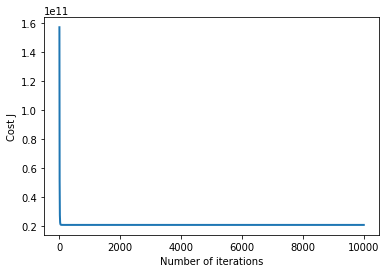

In [16]:
alphah1 = 0.1
num_iterations = 10000
thetah1 = np.zeros(13)

thetah1, J_history = gradientDescentMulti(X_trainnorm, y_train, thetah1, alphah1, num_iterations)

# Plot the convergence graph
pyplot.plot(np.arange(len(J_history)), J_history, lw=2)
pyplot.xlabel('Number of iterations')
pyplot.ylabel('Cost J')

# Display the gradient descent's result
print('theta computed from gradient descent: {:s}'.format(str(thetah1)))


In [17]:
#test 
print(computeCostMulti(X_trainnorm, y_train, thetah1))
print(computeCostMulti(X_valnorm, y_val, thetah1))
print(computeCostMulti(X_testnorm, y_test, thetah1))

20520913922.432255
20547274243.901897
17906075162.654095


In [18]:
# Training data correlation
y_predictedh1train = np.dot(X_trainnorm,thetah1)
correlationh1_train,_ = pearsonr(y_train, y_predictedh1train)
print('Pearsons correlation h1 Training data : %.3f' % correlationh1_train)

Pearsons correlation h1 Training data : 0.808


In [19]:
# Validation data correlation
y_predictedh1val = np.dot(X_valnorm,thetah1)
correlationh1_val,_ = pearsonr(y_val, y_predictedh1val)
print('Pearsons correlation h1 validation data : %.3f' % correlationh1_val)

Pearsons correlation h1 validation data : 0.801


In [20]:
# testing data correlation
y_predictedh1test = np.dot(X_testnorm,thetah1)
correlationh1_test,_ = pearsonr(y_test, y_predictedh1test)
print('Pearsons correlation h1 test data : %.3f' % correlationh1_test)

Pearsons correlation h1 test data : 0.817


# First hypothesis with regularization

In [21]:
thetah1reg = np.zeros(13)
alphareg = 0.01 
lambda_h1reg = 10
Jh1reg, thetah1reg =  costFunctionReg(thetah1reg, X_trainnorm, y_train, lambda_h1reg,alphareg,50000)

# Display the gradient descent's result
print('theta computed from gradient descent using regularization: {:s}'.format(str(thetah1reg)))

theta computed from gradient descent using regularization: [532493.97510094 -31735.22021137  26689.39644102 140664.02285966
 -17326.15243758  13345.25681527  42277.01869593  36749.03742069
  14733.61916682 148618.77524864   2241.69570531 -99593.30580263
   5267.06630488]


In [22]:
# Training data correlation
y_predictedh1trainreg = np.dot(X_trainnorm,thetah1reg)
correlationh1_trainreg,_ = pearsonr(y_train, y_predictedh1trainreg)
print('Pearsons correlation h1 Training data using regularization : %.3f' % correlationh1_trainreg)

Pearsons correlation h1 Training data using regularization : 0.808


In [23]:
# Validation data correlation
y_predictedh1valreg = np.dot(X_valnorm,thetah1reg)
correlationh1_valreg,_ = pearsonr(y_val, y_predictedh1valreg)
print('Pearsons correlation h1 validation data using regularization : %.3f' % correlationh1_valreg)

Pearsons correlation h1 validation data using regularization : 0.801


In [24]:
# Test data correlation
y_predictedh1testreg = np.dot(X_testnorm,thetah1reg)
correlationh1_testreg,_ = pearsonr(y_test, y_predictedh1testreg)
print('Pearsons correlation h1 testing data using regularization : %.3f' % correlationh1_testreg)

Pearsons correlation h1 testing data using regularization : 0.817


In [25]:
print(y_train,y_predictedh1trainreg)

[360000. 200000. 409000. ... 239800. 300000. 375000.] [482087.9508434  416142.95320644 301623.63533858 ... 342238.36517648
 413117.5873061  258641.677907  ]


# Second hypothesis 

In [26]:
def secondhypothesis(X):
    X_new = np.zeros((X.shape[0],5))
    X_new[:,0] = X[:,0]*X[:,1]
    X_new[:,1] = np.square(X[:,2])
    X_new[:,2] = X[:,3]
    X_new[:,3] = X[:,4] * X[:,5]* X[:,6]* X[:,7]* X[:,8]
    X_new[:,4] = X[:,9]
    return X_new

In [27]:
#Transforming features to fit the second hypothesis 
# Training set 
X_trainnormh2 = secondhypothesis(X_train)
# Validation set 
X_valh2 = secondhypothesis(X_val)
#Testing set 
X_testh2 = secondhypothesis(X_test)

#normalzing the sets and adding intercept term

X_trainnormh2 ,muh2,sigmah2 = featureNormalize(X_trainnormh2)
X_testnormh2 = (X_testh2 - muh2)/sigmah2
X_valnormh2 = (X_valh2 - muh2)/sigmah2

X_trainnormh2 = np.concatenate([np.ones((y_train.size, 1)), X_trainnormh2], axis=1)
X_testnormh2 = np.concatenate([np.ones((y_test.size, 1)), X_testnormh2], axis=1)
X_valnormh2 = np.concatenate([np.ones((y_val.size, 1)), X_valnormh2], axis=1)



theta computed from gradient descent: [532852.555815    -4012.9817415  242426.25071891 -21834.50534577
  65838.53130453   9094.95497074]


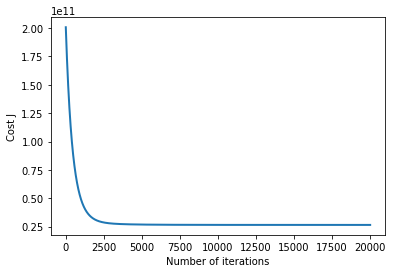

In [28]:
alphah2 = 0.001
num_iterationsh2 = 20000
thetah2 = np.zeros(6)

thetah2, J_historyh2 = gradientDescentMulti(X_trainnormh2, y_train, thetah2, alphah2, num_iterationsh2)

# Plot the convergence graph
pyplot.plot(np.arange(len(J_historyh2)), J_historyh2, lw=2)
pyplot.xlabel('Number of iterations')
pyplot.ylabel('Cost J')

# Display the gradient descent's result
print('theta computed from gradient descent: {:s}'.format(str(thetah2)))

In [29]:
#test 
print(computeCostMulti(X_trainnormh2, y_train, thetah2))
print(computeCostMulti(X_valnormh2, y_val, thetah2))
print(computeCostMulti(X_testnormh2, y_test, thetah2))

26413183120.847885
28006490499.00791
24013460784.76636


In [30]:
# Training data correlation
y_predictedh2train = np.dot(X_trainnormh2,thetah2)
correlationh2_train,_ = pearsonr(y_train, y_predictedh2train)
print('Pearsons correlation h2 Training data : %.3f' % correlationh2_train)

Pearsons correlation h2 Training data : 0.744


In [31]:
# Validation data correlation
y_predictedh2val = np.dot(X_valnormh2,thetah2)
correlationh2_val,_ = pearsonr(y_val, y_predictedh2val)
print('Pearsons correlation h2 validation data : %.3f' % correlationh2_val)

Pearsons correlation h2 validation data : 0.715


In [32]:
# testing data correlation
y_predictedh2test = np.dot(X_testnormh2,thetah2)
correlationh2_test,_ = pearsonr(y_test, y_predictedh2test)
print('Pearsons correlation h2 test data : %.3f' % correlationh2_test)

Pearsons correlation h2 test data : 0.745


Unfortunately the second hypothesis is worse than the first one 

# Third hypothesis 

y = theta0 + (bedrooms + bathrooms) * theta1 + (sqftliving+lotsize+sqftbasement)^2 * theta2 

In [33]:
def thirdhypothesis(X):
    X_new = np.zeros((X.shape[0],2))
    X_new[:,0] = (X[:,0] + X[:,1])
    X_new[:,1] = np.square(X[:,2] + X[:,3] + X[:,9])
    return X_new

In [34]:
#Transforming features to fit the third hypothesis 
# Training set 
X_trainnormh3 = thirdhypothesis(X_train)
# Validation set 
X_valh3 = thirdhypothesis(X_val)
#Testing set 
X_testh3 = thirdhypothesis(X_test)

#normalzing the sets and adding intercept term

X_trainnormh3 ,muh3,sigmah3 = featureNormalize(X_trainnormh3)
X_testnormh3 = (X_testh3 - muh3)/sigmah3
X_valnormh3 = (X_valh3 - muh3)/sigmah3

X_trainnormh3 = np.concatenate([np.ones((y_train.size, 1)), X_trainnormh3], axis=1)
X_testnormh3 = np.concatenate([np.ones((y_test.size, 1)), X_testnormh3], axis=1)
X_valnormh3 = np.concatenate([np.ones((y_val.size, 1)), X_valnormh3], axis=1)


theta computed from gradient descent: [532852.55690236 156445.46200936  20319.2850143 ]


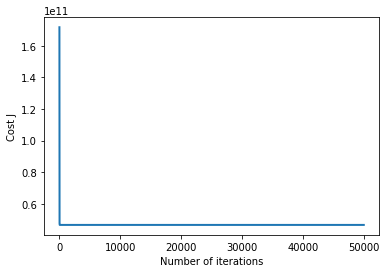

In [35]:
alphah3 = 0.1
num_iterationsh3 = 50000
thetah3 = np.zeros(3)

thetah3, J_historyh3 = gradientDescentMulti(X_trainnormh3, y_train, thetah3, alphah3, num_iterationsh3)

# Plot the convergence graph
pyplot.plot(np.arange(len(J_historyh3)), J_historyh3, lw=2)
pyplot.xlabel('Number of iterations')
pyplot.ylabel('Cost J')

# Display the gradient descent's result
print('theta computed from gradient descent: {:s}'.format(str(thetah3)))

In [36]:
# Training data correlation
y_predictedh3train = np.dot(X_trainnormh3,thetah3)
correlationh3_train,_ = pearsonr(y_train, y_predictedh3train)
print('Pearsons correlation h3 Training data : %.3f' % correlationh3_train)

Pearsons correlation h3 Training data : 0.462


In [37]:
# Validation data correlation
y_predictedh3val = np.dot(X_valnormh3,thetah3)
correlationh3_val,_ = pearsonr(y_val, y_predictedh3val)
print('Pearsons correlation h3 validation data : %.3f' % correlationh3_val)

Pearsons correlation h3 validation data : 0.454


In [38]:
# testing data correlation
y_predictedh3test = np.dot(X_testnormh3,thetah3)
correlationh3_test,_ = pearsonr(y_test, y_predictedh3test)
print('Pearsons correlation h3 test data : %.3f' % correlationh3_test)

Pearsons correlation h3 test data : 0.473


# Kfold sampling for first hypothesis

In [39]:
kf = KFold(10)
counter = 1
for train_index, test_index in kf.split(X):
    X_trainnorm, X_testnorm = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    X_trainnorm = (X_trainnorm -mu) /sigma
    X_testnorm = (X_testnorm -mu) /sigma
    X_trainnorm = np.concatenate([np.ones((y_train.size, 1)), X_trainnorm], axis=1)
    X_testnorm = np.concatenate([np.ones((y_test.size, 1)), X_testnorm], axis=1)
    
    thetah1, J_history = gradientDescentMulti(X_trainnorm, y_train, thetah1, alphah1, num_iterations)
    
    y_predictedh1train = np.dot(X_trainnorm,thetah1)
    correlationh1_train,_ = pearsonr(y_train, y_predictedh1train)
    print('Split: ',counter)
    print('Pearsons correlation h1 Training data: %.3f' % correlationh1_train)
    
    
    y_predictedh1test = np.dot(X_testnorm,thetah1)
    correlationh1_test,_ = pearsonr(y_test, y_predictedh1test)
    print('Pearsons correlation h1 test data  : %.3f'% correlationh1_test)
    counter +=1
    print('\n')

Split:  1
Pearsons correlation h1 Training data: 0.808
Pearsons correlation h1 test data  : 0.809


Split:  2
Pearsons correlation h1 Training data: 0.807
Pearsons correlation h1 test data  : 0.814


Split:  3
Pearsons correlation h1 Training data: 0.808
Pearsons correlation h1 test data  : 0.810


Split:  4
Pearsons correlation h1 Training data: 0.809
Pearsons correlation h1 test data  : 0.801


Split:  5
Pearsons correlation h1 Training data: 0.809
Pearsons correlation h1 test data  : 0.800


Split:  6
Pearsons correlation h1 Training data: 0.807
Pearsons correlation h1 test data  : 0.811


Split:  7
Pearsons correlation h1 Training data: 0.807
Pearsons correlation h1 test data  : 0.810


Split:  8
Pearsons correlation h1 Training data: 0.807
Pearsons correlation h1 test data  : 0.813


Split:  9
Pearsons correlation h1 Training data: 0.807
Pearsons correlation h1 test data  : 0.811


Split:  10
Pearsons correlation h1 Training data: 0.809
Pearsons correlation h1 test data  : 0.804

